# Use: Tests of `BenamouBrenier.py`

In [22]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
from warnings import warn
from tqdm.notebook import tqdm,trange # to display loading bars
%load_ext autoreload
%autoreload 2

from BenamouBrenier import TransportProblem
from transport import gaussian_transport, gaussian_discreatization, random_gaussian_parameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
rng = np.random.default_rng(123)
from scipy.stats import multivariate_normal
from matplotlib.widgets import Slider
N=20
T=N
mesh= np.array(np.meshgrid(np.linspace(0,1,N),np.linspace(0,1,N)))

#mean1, cov1 = random_gaussian_parameters(2,rng)
#mean2, cov2 = random_gaussian_parameters(2,rng)
mean1, cov1 = 0.4 * np.ones((2)), np.eye(2)/100
mean2, cov2 = 0.6 * np.ones((2)), np.eye(2)/100

mu,nu = np.empty((N,N)),np.empty((N,N))
for idx in np.ndindex((N,N)):
    mu[idx] = multivariate_normal.pdf(mesh[(...,*idx)], mean1, cov1)
    nu[idx] = multivariate_normal.pdf(mesh[(...,*idx)], mean2, cov2)
mu = mu/np.mean(mu)
nu = nu/np.mean(nu)
prob1 = TransportProblem(mesh,mu,nu,T)
prob1.solve(maxiter=30)
%matplotlib
prob1.plot()


TransportProblem object initialized.


  0%|          | 0/30 [00:00<?, ?it/s]

/Users/benoitmuller/Documents/GitHub/Computational-Optimal-Transport/BenamouBrenier.py:158: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(self.rho * np.abs(self.residual())) / np.sum(self.rho * np.sum(self.nabla_phi[1:]**2,axis=0))


Benamou-Brenier method stopped at the maximum number of iterations, with criterium =  466.1421284000041 > 1e-05 .
Using matplotlib backend: <object object at 0x7fc6a7b6f200>


## Poisson step
- used centered $O(h^2)$ finite difference, with ghost point for Neumann bc
- the source term is a divergence and we need acces to $\nabla\phi$, done with centered $O(h^2)$ finite difference except on the Numann boundary where it is $O(h)$
- System underdetermined, used kernel orthogonality

## Steps
- **Projection Step**:
    - Analytic solution complicated and numerically instable. reduce the problem to 1D (grid-wise), and use Newton method to solve the polynomial equation of orthogonality. [Algorithms for projecting points onto conics](https://www.sciencedirect.com/science/article/pii/S0377042713001398#s000005)
    - choice of the initial point ([desmos graphic](https://www.desmos.com/calculator/nj6gcjfbaq)) to get the right zero.
- **Dual Step**: easy
- **Poisson Step**:
- What is the Domain $\Omega\subset\mathbb{R}^d$, should contain the support of $\mu$ and $\nu$?
- gaussian transport
    - restrict to an ellipsis support of $\mu$ and renormalise (polar coord and 1D normal distribution)
    - the transport map is still optimal and lead to an ellipsis support, and is still optimal.

In [44]:
%matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.widgets import Slider


fig, (ax1,ax2) = plt.subplots(2)

s = Slider(ax = ax2, label = 'value', valmin = 0, valmax = N-1, valinit = 0)

def update(val):
    value=int(s.val)
    ax1.cla()
    ax1.contour(prob1.rho[value])

s.on_changed(update)
update(0)

plt.show()

Using matplotlib backend: <object object at 0x7fcad63acdb0>


## 3D Poisson solver
Solver of the 3D poisson equation with time Neumann heterogenous conditions and space periodic conditions.

In [ ]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

from poisson import *

nn = 5 + 2*np.arange(5)
order = "F"

uex = lambda x,y,z: -1 + x**2 + np.sin(2*np.pi*y) + np.sin(4*np.pi*z)
f = lambda x,y,z:  0*x + 2 - (2*np.pi)**2 * np.sin(2*np.pi*y) - (4*np.pi)**2 * np.sin(4*np.pi*z)
err = np.empty_like(nn)
for i,n in enumerate(nn):
    x=np.linspace(0,1,n)[:,None,None]
    y=np.linspace(0,1,n)[None,:,None]
    z=np.linspace(0,1,n)[None,None,:]
    uex_vect = uex(x,y,z)
    f_vect = f(x,y,z)
    g_vect = np.array([np.zeros((n,n)), 2*np.ones((n,n))])

    u,A,b,u_vect = poisson(f_vect,g_vect)

    u = u - np.mean(u) + np.mean(uex_vect)
    res = A.dot(u_vect) - b
    err[i] = np.max(np.abs(u-uex_vect))
plt.semilogy(nn,err,'.-')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyboardInterrupt: 

integral of u:            -0.6538461538461539
integral of uex:          -0.6538461538461539
max-norm of the error:    0.8735878416938525
L1-norm of the error:    0.22880454409182674
residual 2-norm:         0.4848732213850631


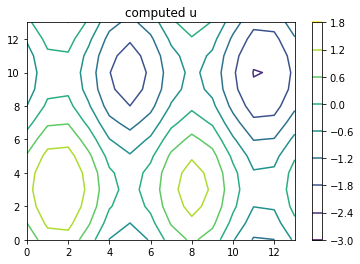

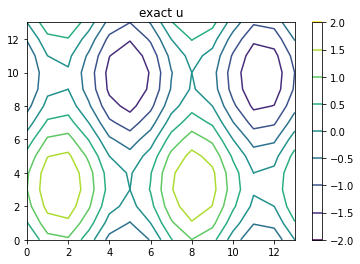

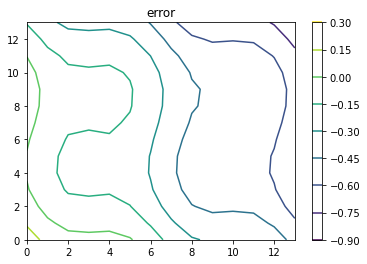

In [38]:
print("integral of u:           ", np.sum(u) / n**3)
print("integral of uex:         ", np.sum(uex_vect) / n**3)
print("max-norm of the error:   ", np.max(np.abs(u-uex_vect)))
print("L1-norm of the error:   ", np.mean(np.abs(u-uex_vect)))
print("residual 2-norm:        ", np.linalg.norm(res))

i=n-1
plt.figure()
plt.title("computed u")
plt.contour(u[i,:,:])
plt.colorbar()

plt.figure()
plt.title("exact u")
plt.contour(uex_vect[i,:,:])
plt.colorbar()

plt.figure()
plt.title("error")
plt.contour((u-uex_vect)[i,:,:])
plt.colorbar()